In [21]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
from random import randrange
import pylab

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [4]:
display(Image(filename="/home/goncalo/udacity_tensorflow_assigmetns/1-NotMNIST/notMNIST_small/A/SWNlY3ViZS50dGY=.png"))

In [6]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file, mode='F').astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image (%s) shape: %s' % (image_file, str(image_data.shape)))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_folder_name = "/home/goncalo/udacity_tensorflow_assigmetns/1-NotMNIST/notMNIST_large/"
train_folders = [train_folder_name + x for x in ("A", "B", "C", "D", "E", "F", "G", "H", "I", "J")]
test_folder_name = "/home/goncalo/udacity_tensorflow_assigmetns/1-NotMNIST/notMNIST_small/"
test_folders = [test_folder_name + x for x in ("A", "B", "C", "D", "E", "F", "G", "H", "I", "J")]

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

/home/goncalo/udacity_tensorflow_assigmetns/1-NotMNIST/notMNIST_large/A.pickle already present - Skipping pickling.
/home/goncalo/udacity_tensorflow_assigmetns/1-NotMNIST/notMNIST_large/B.pickle already present - Skipping pickling.
/home/goncalo/udacity_tensorflow_assigmetns/1-NotMNIST/notMNIST_large/C.pickle already present - Skipping pickling.
/home/goncalo/udacity_tensorflow_assigmetns/1-NotMNIST/notMNIST_large/D.pickle already present - Skipping pickling.
/home/goncalo/udacity_tensorflow_assigmetns/1-NotMNIST/notMNIST_large/E.pickle already present - Skipping pickling.
/home/goncalo/udacity_tensorflow_assigmetns/1-NotMNIST/notMNIST_large/F.pickle already present - Skipping pickling.
/home/goncalo/udacity_tensorflow_assigmetns/1-NotMNIST/notMNIST_large/G.pickle already present - Skipping pickling.
/home/goncalo/udacity_tensorflow_assigmetns/1-NotMNIST/notMNIST_large/H.pickle already present - Skipping pickling.
/home/goncalo/udacity_tensorflow_assigmetns/1-NotMNIST/notMNIST_large/I.

In [7]:
os.listdir("/home/goncalo/udacity_tensorflow_assigmetns/1-NotMNIST/notMNIST_large/")

['H', 'G', 'B', 'J', 'F', 'D', 'C', 'A', 'E', 'I']

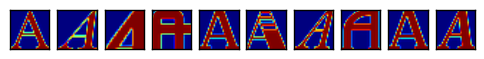

In [37]:
f = plt.figure()
for i in range(0,10):
    plot = f.add_subplot(1,10,i+1)
    plt.imshow(np.load(train_datasets[0])[randrange(0,50)])
    plot.axes.get_xaxis().set_visible(False)
    plot.axes.get_yaxis().set_visible(False)
plt.show()
    